# Libraries 📚

In [19]:
import glob
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import time

# IPNYB
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Autoencoder
# Model and performance
import tensorflow as tf
from tensorflow.keras import losses, layers
from tensorflow.keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer

# Code 💻

## Functions

In [26]:
def load_select_resolution(dx, dy):
        '''
        Selects the resolution of the matrices to load.
        dx: the x resolution
        dy: the y resolution
        return: None
        '''
        global X, y, nX, ny
        
        if dx == 0.1 and dy == 0.1:
                # Load matrices from previously generated files
                X_01 = np.load('matrices/X_01.npy')
                y_01 = np.load('matrices/y_01.npy')
                X = X_01
                y = y_01
                
                print(f'Matrix shapes -> X: {X_01.shape}, y: {y_01.shape}')
                        
        elif dx == 0.3 and dy == 0.3:
                # Load matrices from previously generated files
                X_03 = np.load('matrices/X_03.npy')
                y_03 = np.load('matrices/y_03.npy')
                nX = np.load('matrices/nX.npy')
                ny = np.load('matrices/ny.npy')
                X = X_03
                y = y_03
                print(f'Matrix shapes -> X: {X_03.shape}, y: {y_03.shape}, nX: {nX.shape}, ny: {ny.shape}')        
        return None

def tts(X, y, dx=0.1, dy=0.1):
        # Muons --------------------------------------------------------------
        print('Muons:')
        # Use X and y to recover the muon events
        muons = X[y == 1]
        muon_labels = y[y == 1]

        X_train, X_test, y_train, y_test = train_test_split(muons, muon_labels, test_size=0.2)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

        # Normalizing the data
        # We will use the function normalize from keras.utils to normalize the data.
        # We will normalize the data by dividing the data by the maximum value of the data.
        X_train = keras.utils.normalize(X_train, axis=1)
        X_val = keras.utils.normalize(X_val, axis=1)
        X_test = keras.utils.normalize(X_test, axis=1)

        # Reshape the y data to be a column one-hot encoded vector.
        y_train = keras.utils.to_categorical(y_train, 2)
        y_val = keras.utils.to_categorical(y_val, 2)
        y_test = keras.utils.to_categorical(y_test, 2)

        # Check the number of records
        print('The number of records in the training dataset is', X_train.shape[0])
        print('The number of records in the test dataset is', X_test.shape[0])

        print(f"Muon shapes: Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}, Train labels: {y_train.shape}, Val labels: {y_val.shape}, Test labels: {y_test.shape}")
        # Show target vector (1 = muon, 0 = antimuon)
        #print(f"Muon target training vector: {y_train}")

        print(' ')
        print(' ')

        # Antimuons --------------------------------------------------------------
        print('Antimuons')
        # Use X and y to recover the antimuon events
        antimuons = X[y == 0]
        antimuon_labels = y[y == 0]

        # Train test split for antimuon data
        aX_train, aX_test, ay_train, ay_test = train_test_split(antimuons, antimuon_labels, test_size=0.2)
        aX_train, aX_val, ay_train, ay_val = train_test_split(aX_train, ay_train, test_size=0.2)

        # Normalizing the data
        # We will use the function normalize from keras.utils to normalize the data.
        # We will normalize the data by dividing the data by the maximum value of the data.
        aX_train = keras.utils.normalize(aX_train, axis=1)
        aX_val = keras.utils.normalize(aX_val, axis=1)
        aX_test = keras.utils.normalize(aX_test, axis=1)

        ay_train = keras.utils.to_categorical(ay_train, 2)
        ay_val = keras.utils.to_categorical(ay_val, 2)
        ay_test = keras.utils.to_categorical(ay_test, 2)

        # Check the number of records
        print('The number of records in the training dataset is', aX_train.shape[0])
        print('The number of records in the test dataset is', aX_test.shape[0])
        print(f"Antimuon shapes: Train: {aX_train.shape}, Val: {aX_val.shape}, Test: {aX_test.shape}, Train labels: {ay_train.shape}, Val labels: {ay_val.shape}, Test labels: {ay_test.shape}")

        if dx == 0.3 and dy == 0.3:
                print(' ')
                print(' ')
                # Neutrons --------------------------------------------------------------
                print('Neutrons')
                # Normalizing the data
                nX = keras.utils.normalize(nX, axis=1)
                print(f"Neutron shapes: {nX.shape, ny.shape}")
                return X_train, X_val, X_test, y_train, y_val, y_test, aX_train, aX_val, aX_test, ay_train, ay_val, ay_test, nX, ny
        
        else:
                return X_train, X_val, X_test, y_train, y_val, y_test, aX_train, aX_val, aX_test, ay_train, ay_val, ay_test

def reconstruction_error_plot(model, X_test, aX_test, nX=None):
        '''
        Shows a plot of the reconstruction error for muons and antimuons. Neutrons are optional.
        model: the autoencoder model
        X_test: the muon test set
        aX_test: the antimuon test set
        nX: the neutron set (optional)
        return: None
        '''
        
        # Predict on the test set
        X_test_pred = model.predict(X_test)
        aX_test_pred = model.predict(aX_test)

        # Calculate the mean squared error
        X_test_pred_mse_loss = tf.keras.losses.mse(X_test_pred, X_test)
        aX_test_pred_mse_loss = tf.keras.losses.mse(aX_test_pred, aX_test)

        # Mean over the side and channel axes
        X_test_pred_mse_loss = np.mean(X_test_pred_mse_loss, axis=(1,2))
        aX_test_pred_mse_loss = np.mean(aX_test_pred_mse_loss, axis=(1,2))
        
        # Plot the distribution of the reconstruction loss
        plt.figure(figsize=(10, 7))
        plt.scatter(range(len(X_test_pred_mse_loss)), X_test_pred_mse_loss, color='red', label='Reconstruction loss muons')
        plt.scatter(range(len(aX_test_pred_mse_loss)), aX_test_pred_mse_loss, color='blue', label='Reconstruction loss antimuons')
        
        if nX is not None:
            nX_pred = model.predict(nX)
            nX_pred_mse_loss = tf.keras.losses.mse(nX_pred, nX)
            nX_pred_mse_loss = np.mean(nX_pred_mse_loss, axis=(1,2))
            plt.scatter(range(len(nX_pred_mse_loss)), nX_pred_mse_loss, color='green', label='Reconstruction loss neutrons')
            
        plt.xlabel('Event')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE Error Reconstruction')
        plt.legend()
        plt.show()
        return None

def reconstruction_error(model, X_test, aX_test, nX=None):
        '''
        Returns a tuple with the reconstruction error for muons and antimuons. Neutrons are optional.
        model: the autoencoder model
        X_test: the muon test set
        aX_test: the antimuon test set
        nX: the neutron set (optional)
        return: tuple
                if nX is None: (X_test_pred_mse_loss, aX_test_pred_mse_loss)
                else: (X_test_pred_mse_loss, aX_test_pred_mse_loss, nX_pred_mse_loss)
        '''
        # Predict on the test set
        X_test_pred = model.predict(X_test)
        aX_test_pred = model.predict(aX_test)
        
        # Calculate the mean squared error
        X_test_pred_mse_loss = tf.keras.losses.mse(X_test_pred, X_test)
        aX_test_pred_mse_loss = tf.keras.losses.mse(aX_test_pred, aX_test)

        # Mean over the side and channel axes
        X_test_pred_mse_loss = np.mean(X_test_pred_mse_loss, axis=(1,2))
        aX_test_pred_mse_loss = np.mean(aX_test_pred_mse_loss, axis=(1,2))
        
        if nX is not None:
            nX_pred = model.predict(nX)
            nX_pred_mse_loss = tf.keras.losses.mse(nX_pred, nX)
            nX_pred_mse_loss = np.mean(nX_pred_mse_loss, axis=(1,2))
            
        return (X_test_pred_mse_loss, aX_test_pred_mse_loss, nX_pred_mse_loss) if nX is not None else (X_test_pred_mse_loss, aX_test_pred_mse_loss)

def particle_compare_plot(pX_test, py_test, pX_test_pred):
        random_events = np.random.randint(0, pX_test.shape[0], 1)
        print(f'Event number: {random_events}')

        for i in random_events:
                fig, axs = plt.subplots(1, 4, figsize=(20, 7))
                
                # Event
                axs[0].imshow(pX_test[i,:,:,0], cmap='Reds')
                axs[0].set_title('Muon' if py_test[i][0] == 0 else 'Antimuon')
                axs[1].imshow(pX_test[i,:,:,1], cmap='Blues')
                axs[1].set_title('Muon' if py_test[i][0] == 0 else 'Antimuon')
                
                # Reconstructed event
                axs[2].imshow(pX_test_pred[i,:,:,0], cmap='Reds')
                axs[2].set_title('Muon - Reconstruction' if py_test[i][0] == 0 else 'Antimuon - Reconstruction')
                axs[3].imshow(pX_test_pred[i,:,:,1], cmap='Blues')
                axs[3].set_title('Muon - Reconstruction' if py_test[i][0] == 0 else 'Antimuon - Reconstruction')
                
                # Show tick labels on both sides
                axs[0].tick_params('x', labelbottom=True, labeltop=True)
                axs[0].tick_params('y', labelleft=True, labelright=True)
                axs[0].set_xlabel('Side 1')
                
                axs[1].tick_params('x', labelbottom=True, labeltop=True)
                axs[1].tick_params('y', labelleft=True, labelright=True)
                axs[1].set_xlabel('Side 2')
                
                # Show tick labels on both sides
                axs[2].tick_params('x', labelbottom=True, labeltop=True)
                axs[2].tick_params('y', labelleft=True, labelright=True)
                axs[2].set_xlabel('Side 1')
                
                axs[3].tick_params('x', labelbottom=True, labeltop=True)
                axs[3].tick_params('y', labelleft=True, labelright=True)
                axs[3].set_xlabel('Side 2')
                
        plt.show()

## Load Data

In [15]:
dx = 0.1
dy = 0.1

load_select_resolution(dx, dy)
mX_train, mX_val, mX_test, my_train, my_val, my_test, aX_train, aX_val, aX_test, ay_train, ay_val, ay_test = tts(X, y)

Matrix shapes -> X: (10233, 21, 15, 2), y: (10233,)
Muons:
The number of records in the training dataset is 3336
The number of records in the test dataset is 1043
Muon shapes: Train: (3336, 21, 15, 2), Val: (835, 21, 15, 2), Test: (1043, 21, 15, 2), Train labels: (3336, 2), Val labels: (835, 2), Test labels: (1043, 2)
 
 
Antimuons
The number of records in the training dataset is 3212
The number of records in the test dataset is 1004
Antimuon shapes: Train: (3212, 21, 15, 2), Val: (803, 21, 15, 2), Test: (1004, 21, 15, 2), Train labels: (3212, 2), Val labels: (803, 2), Test labels: (1004, 2)


## Plot random event

[1325]


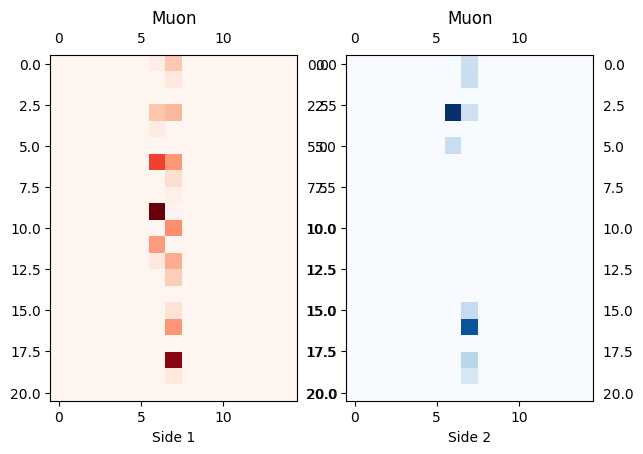

In [17]:
# Plotting a muon event from the training set.
random_events = np.random.randint(0, mX_train.shape[0], 1)
print(random_events)

for i in random_events:
        fig, axs = plt.subplots(1, 2, figsize=(7, 7))
        axs[0].imshow(mX_train[i,:,:,0], cmap='Reds')
        axs[0].set_title('Muon' if my_train[i][0] == 0 else 'Antimuon')
        axs[1].imshow(mX_train[i,:,:,1], cmap='Blues')
        axs[1].set_title('Muon' if my_train[i][0] == 0 else 'Antimuon')
        # Show tick labels on both sides
        axs[0].tick_params('x', labelbottom=True, labeltop=True)
        axs[0].tick_params('y', labelleft=True, labelright=True)
        axs[1].tick_params('x', labelbottom=True, labeltop=True)
        axs[1].tick_params('y', labelleft=True, labelright=True)
        axs[0].set_xlabel('Side 1')
        axs[1].set_xlabel('Side 2')
        
plt.show()

## Autoencoder 1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 21, 15, 2)]       0         
                                                                 
 sequential (Sequential)     (None, 5)                 419907    
                                                                 
 sequential_1 (Sequential)   (None, 21, 15, 2)         23032     
                                                                 
Total params: 442,939
Trainable params: 442,939
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
105/105 [==============================] - 2s 6ms/step - loss: 0.0074 - accuracy: 0.7711 - val_loss: 0.0069 - val_accuracy: 0.8487
Epoch 2/30
105/105 [==============================] - 0s 4ms/step - loss: 0.0067 - accuracy: 0.8929 - val_loss: 0.0064 - val_accuracy: 0.9123
Epoch 3/30
105/105 [===============

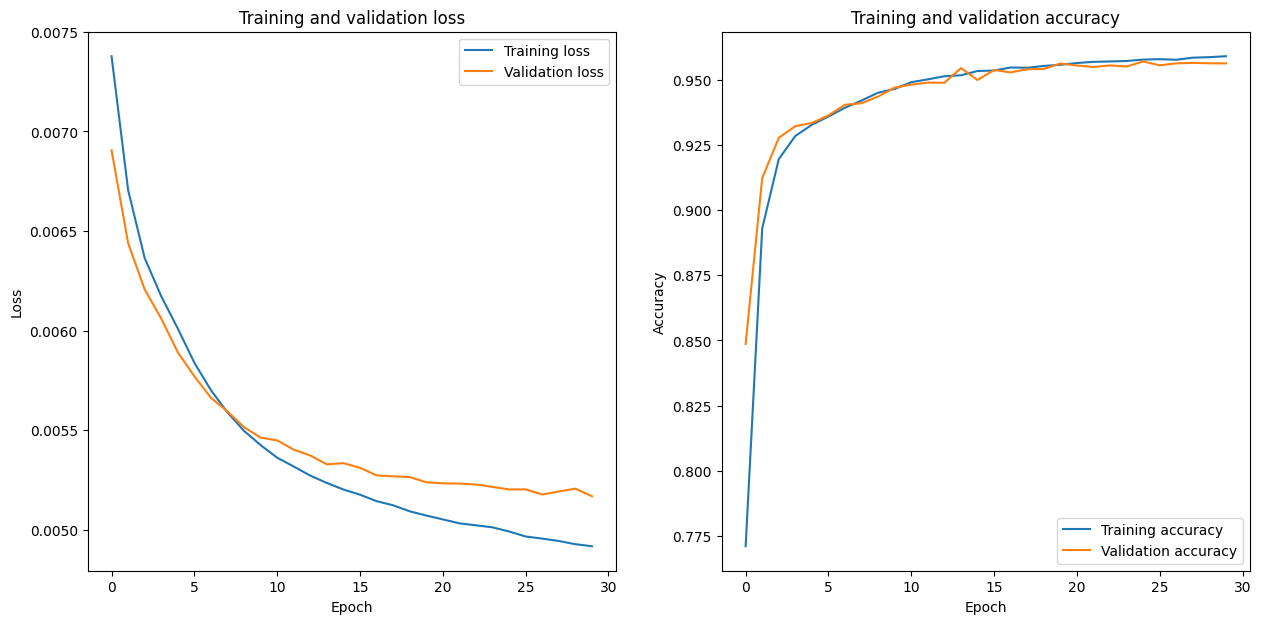

In [20]:
# We will train the autoencoder model using only the muon training set.
MATRIX_SHAPE = X_train.shape[1:]

# Input layer: the input are images with two channels (side 1 and side 2), each image has a 7x5 resolution (7,5,2)
input = tf.keras.layers.Input(shape=(MATRIX_SHAPE))
activation_function = 'relu'

# Encoder layers
encoder = tf.keras.Sequential([
  layers.Flatten(),
  layers.Dense(np.prod(MATRIX_SHAPE), activation=activation_function),
  layers.Dense(35, activation=activation_function),
  layers.Dense(7, activation=activation_function),
  layers.Dense(5, activation=activation_function)])(input)

# Decoder layers
decoder = tf.keras.Sequential([
      layers.Dense(5, activation=activation_function),
      layers.Dense(7, activation=activation_function),
      layers.Dense(35, activation=activation_function),
      layers.Dense(np.prod(MATRIX_SHAPE), activation=activation_function),
      layers.Reshape(MATRIX_SHAPE)])(encoder)

# Create the autoencoder
autoencoder_1 = Model(input, decoder)

# Compile the autoencoder
autoencoder_1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder_1.summary()

# Fit the autoencoder
start = time.time()
history = autoencoder_1.fit(X_train, X_train, 
          epochs=30, 
          validation_data=(X_val, X_val),
          shuffle=True)
end = time.time()
print('Training time:', end - start)

# Plotting the training and validation loss and accuracy

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].plot(history.history['loss'], label='Training loss')
axs[0].plot(history.history['val_loss'], label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(history.history['accuracy'], label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation accuracy')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

### MSE Reconstruction Error 1

32/32 [==============================] - 0s 1ms/step


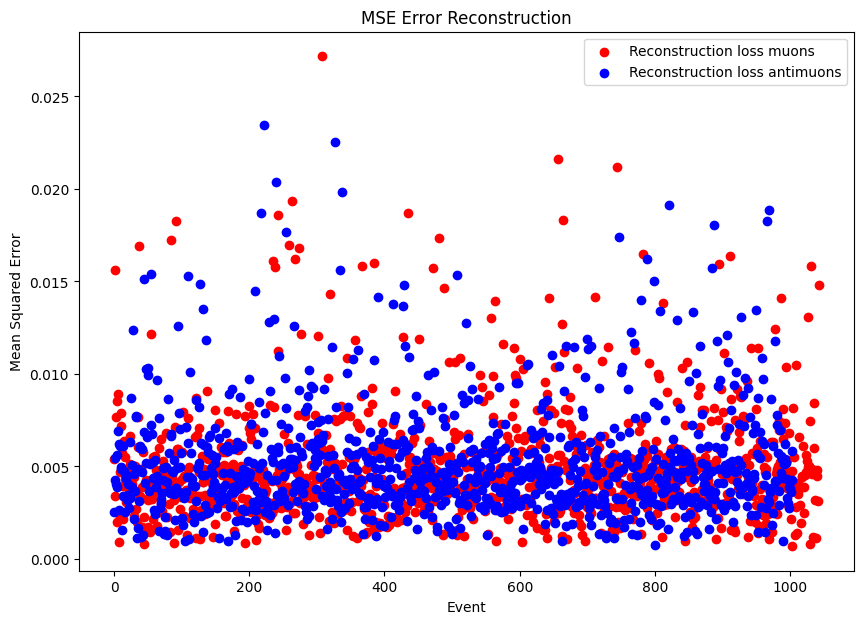

In [23]:
# Plot the difference between the input and the reconstructed output, we want to make sure that data is not separable so we feed the antimuon data to the autoencoder.
# We expect the reconstructed output caused by antimuon data to be non differentiable from the input.

reconstruction_error_plot(autoencoder_1, mX_test, aX_test)

### Comparing original vs reconstructed particle showers

#### Muon

 1/33 [..............................] - ETA: 1s

33/33 [==============================] - 0s 4ms/step
Event number: [532]


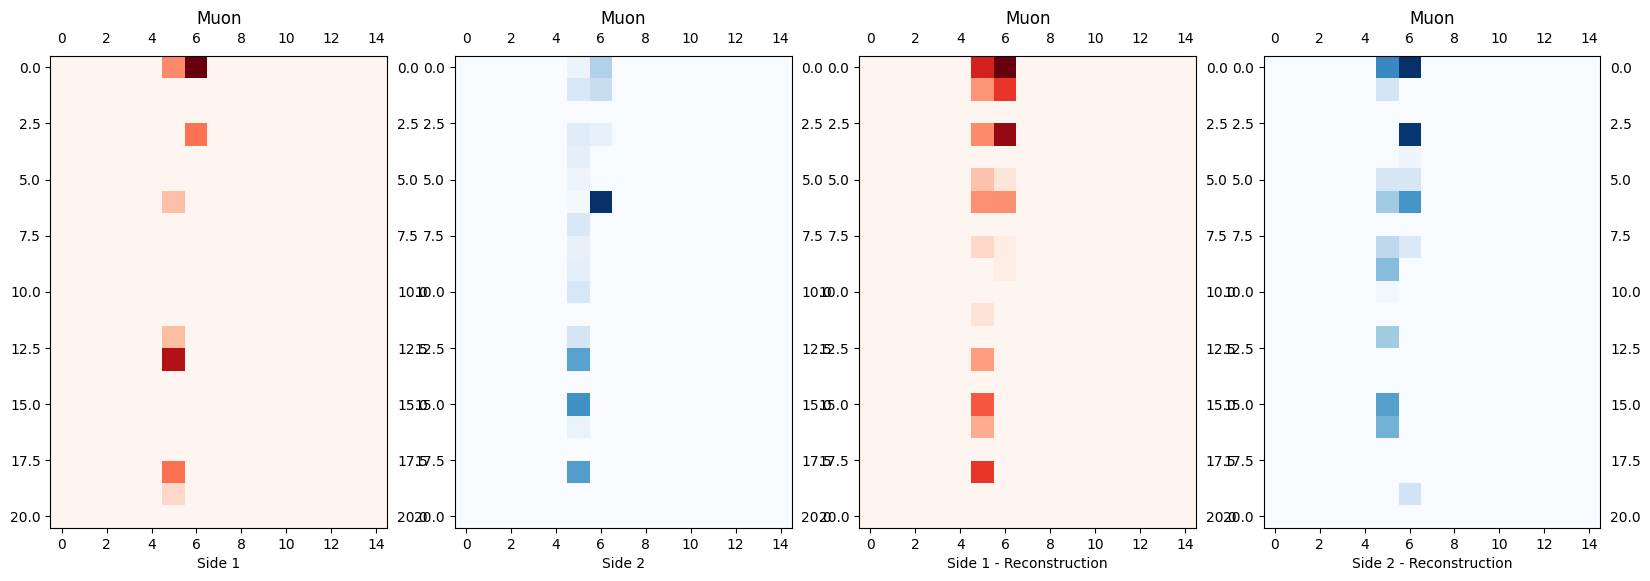

In [30]:
particle_compare_plot(mX_test, my_test, autoencoder_1.predict(mX_test))

#### Antimuon

32/32 [==============================] - 0s 3ms/step
Event number: [517]


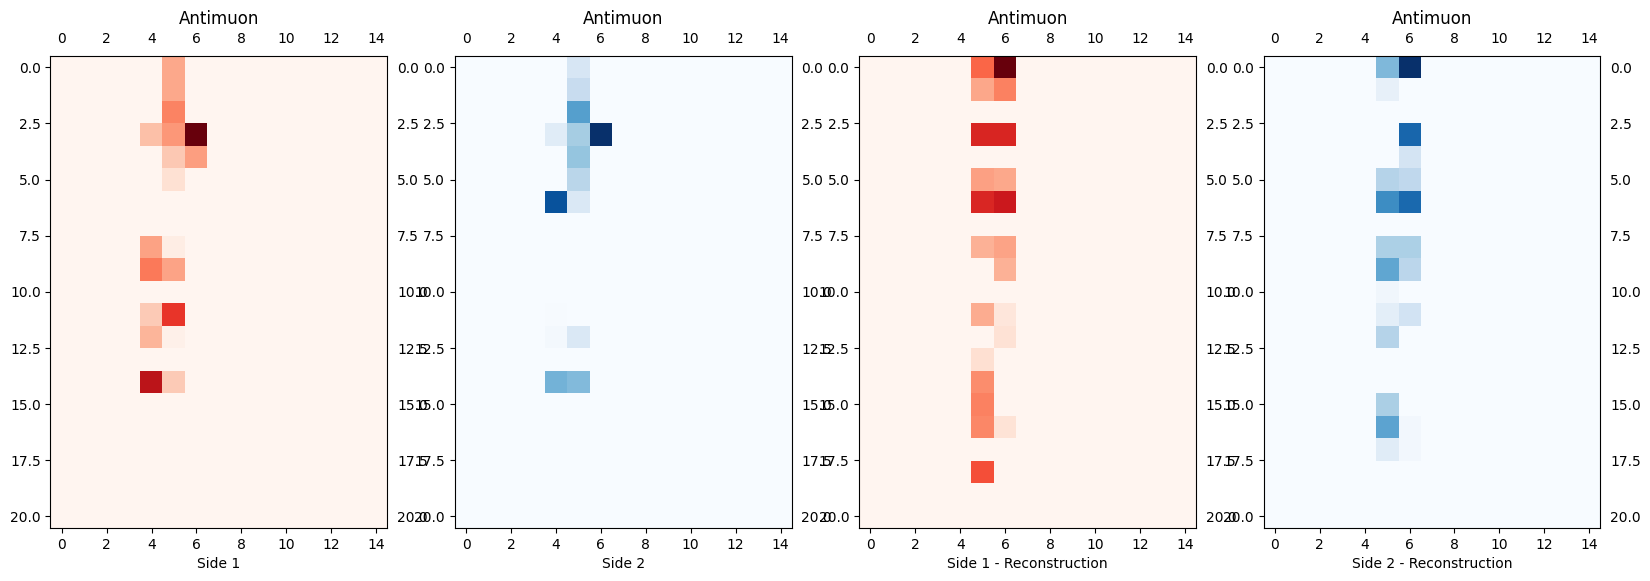

In [31]:
particle_compare_plot(aX_test, ay_test, autoencoder_1.predict(aX_test))

## Autoencoder 2

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 15, 2), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 21, 15, 2)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 32)                20192     
                                                                 
 sequential_3 (Sequential)   (None, 21, 15, 2)         20790     
                                                                 
Total params: 40,982
Trainable params: 40,982
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
105/105 [==============================] - 1s 4ms/step - loss: 0.0069 - accuracy: 0.7888 - val_loss: 0.0057 - val_accuracy: 0.8793
Epoch 2/30
105/105 [=

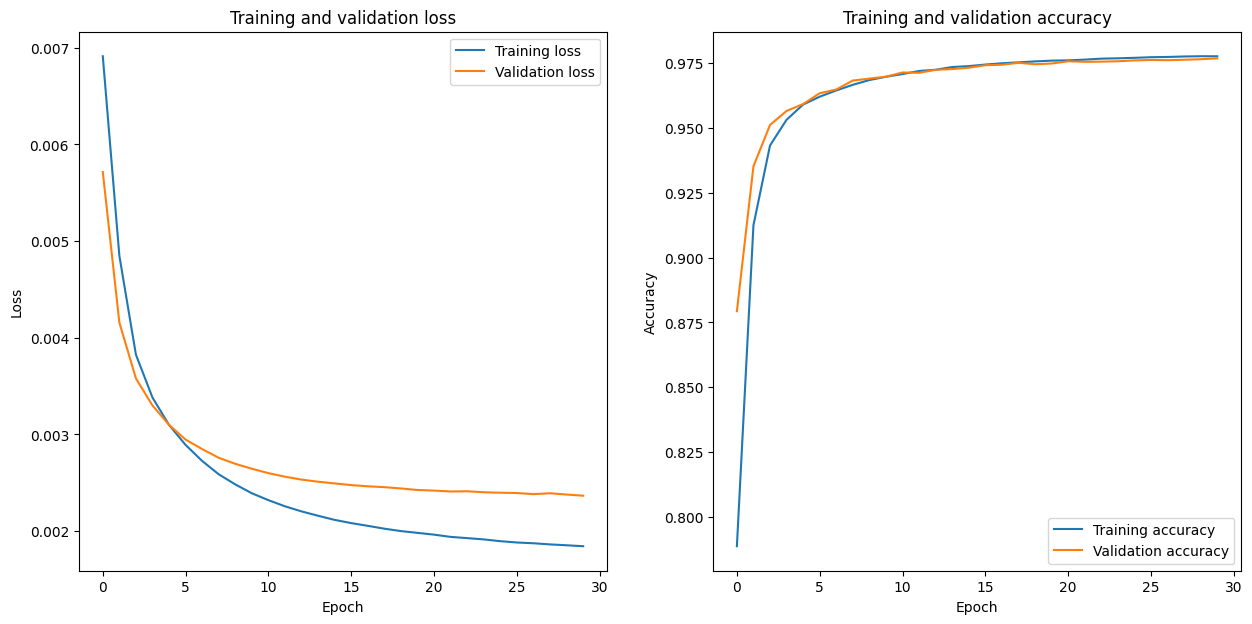

In [24]:
def build_autoencoder(img_shape, code_size, activation_function):
    # Encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size, activation=activation_function))
    
    # Decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape), activation=activation_function)) # np.prod(img_shape) is the same as 7*5*2, it's more generic than saying 70
    decoder.add(Reshape(img_shape))

    return encoder, decoder

MATRIX_SHAPE = X_train.shape[1:]
print(Input(MATRIX_SHAPE))
activation_function = 'relu'
encoder, decoder = build_autoencoder(MATRIX_SHAPE, 32, activation_function)

inp = Input(MATRIX_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder_2 = Model(inp, reconstruction)
autoencoder_2.compile(optimizer='adam', loss='mse', metrics="accuracy")
print(autoencoder_2.summary())

# Fit the autoencoder
start = time.time()
history = autoencoder_2.fit(X_train, X_train, 
          epochs=30, 
          validation_data=(X_val, X_val),
          shuffle=True)
end = time.time()
print('Training time:', end - start)

# Plotting the training and validation loss and accuracy

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].plot(history.history['loss'], label='Training loss')
axs[0].plot(history.history['val_loss'], label='Validation loss')
axs[0].set_title('Training and validation loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(history.history['accuracy'], label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation accuracy')
axs[1].set_title('Training and validation accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.show()

### MSE Reconstruction Error 2

32/32 [==============================] - 0s 1ms/step


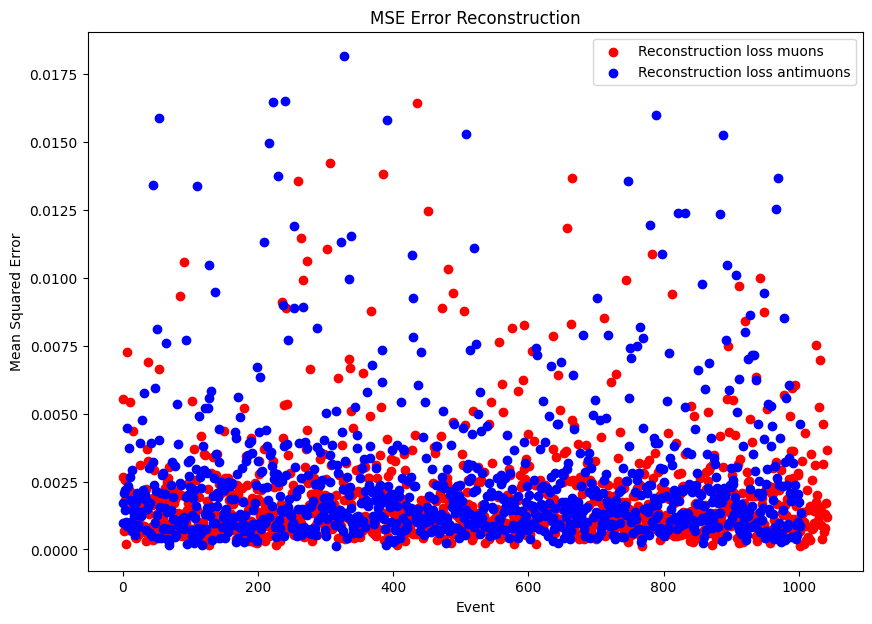

In [25]:
reconstruction_error_plot(autoencoder_2, mX_test, aX_test)

### Comparing original vs reconstructed particle showers

#### Muon

33/33 [==============================] - 0s 4ms/step
Event number: [394]


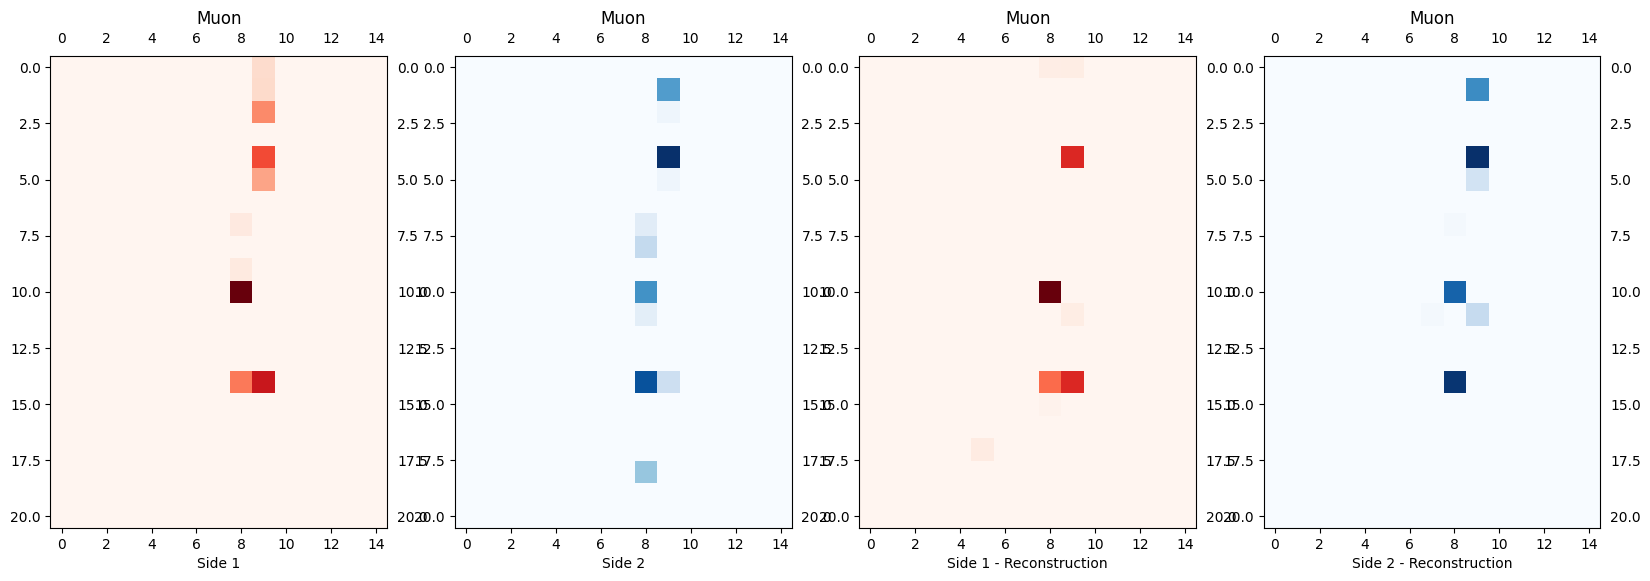

In [32]:
particle_compare_plot(mX_test, my_test, autoencoder_2.predict(mX_test))

#### Antimuon

32/32 [==============================] - 0s 3ms/step
Event number: [768]


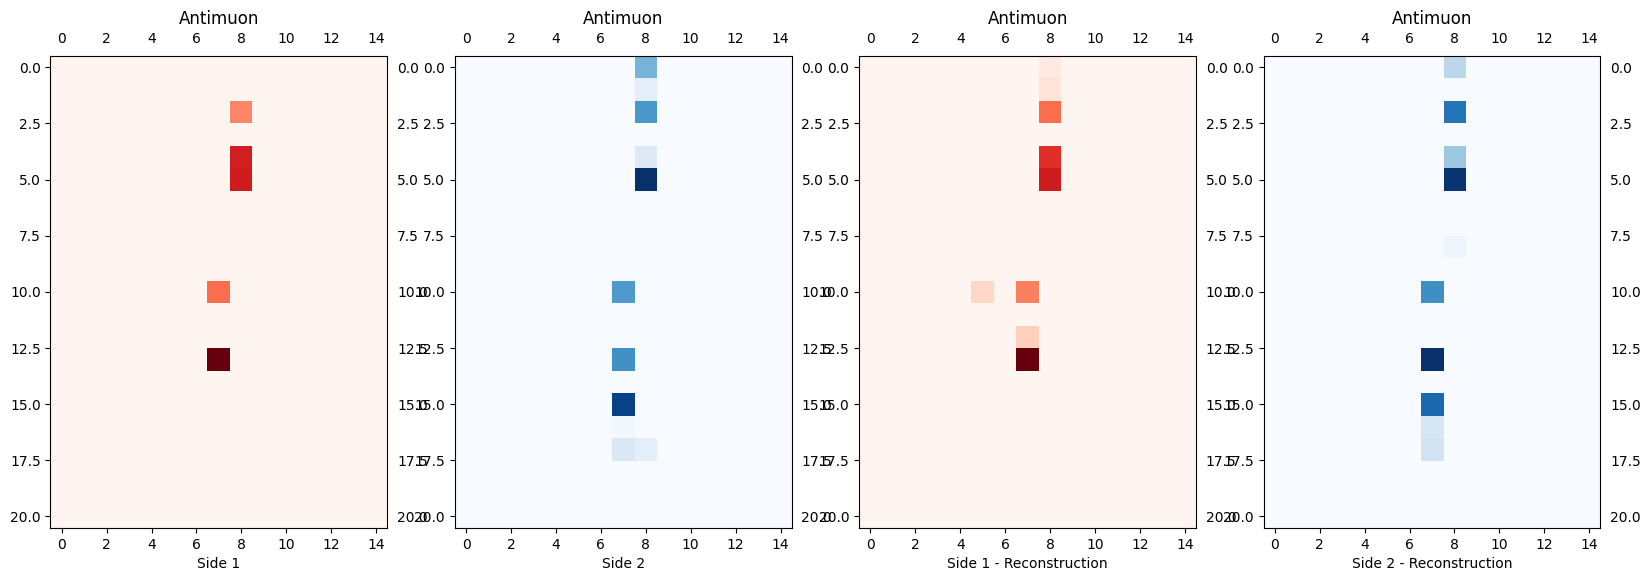

In [33]:
particle_compare_plot(aX_test, ay_test, autoencoder_2.predict(aX_test))